**BIVARIATE**

* Categorical vs Categorical Target --> Count + pct for each category and target category; Count + pct for each target category; Grouped count plot with hue=target; Grouped bar plot with percentages with hue=target and lines indicating target percentages without grouping

* Categorical vs Numerical Target --> Descibe for numerical target alone and for each category; Boxplot for each category with reference line with mean(median) for target alone; overlapping distributions for each value of categorical variable; QQ-plot 

* Numerical vs Categorical Target --> Describe for numerical variable alone and for each target category; Boxplot for each category with reference line with mean (median) for variable alone; overlapping distributions for each value of target variable; QQ-plot

* Numerical vs Numerical target --> Describe for both variable and target; Correlation values; Scatterplot


**TRIVARIATE**

* 2 Categorical vs Categorical target --> Count + pct for each category and target category; Count + pct for each target category; For each value of target, two heatmaps: one with percentages of the corresponding value for each pair of category values, and one with the difference between the first one, and the pct of the target value without grouping.

* 2 categorical vs numerical target --> Grouped boxplot with x=categorical, y=target, hue=categorical

* 1 Categorical, 1 Numerical vs Categorical target --> Grouped boxplot with x=Categorical, y=numerical, hue=target

* 1 Categorical, 1 Numerical vs Numerical target --> Scatterplot with hue=categorical

* 2 Numerical vs Categorical target --> Scatterplot with hue=target

* 2 Numerical vs numerical target --> heatmap


In [1]:
'''
Helper functions to do EDA
'''

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

In [2]:
sns.__version__

'0.11.0'

## Read Data

In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'titanic')

In [4]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_df["Pclass"] = train_df["Pclass"].astype("category") 

## Bivariate plots

In [32]:
%load_ext autoreload
%autoreload 2

In [28]:
#del sys.modules['AutoEDA']
del test

In [42]:
import sys, importlib
#importlib.reload(sys.modules['AutoEDA'])
import AutoEDA.AutoEDA as eda
#import AutoEDA as eda

In [45]:
eda.test()

'test3'

In [46]:
column_cat, column_num = "Pclass", "Age"
column_num1, column_num2 = "Age", "Fare"
dataframe = train_df

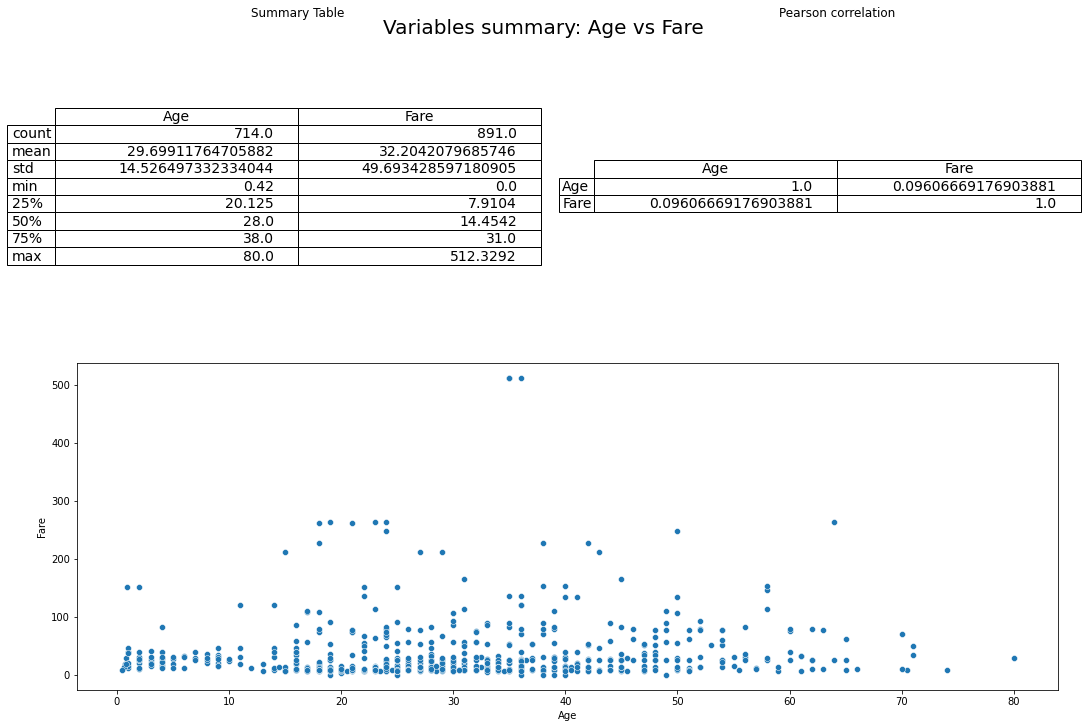

In [55]:
eda.numerical_vs_numerical(dataframe, column_num1, column_num2, 
                         palette=None, ax=None, order=None)